## Setup

In [37]:
import pandas as pd
import numpy as np
import geopandas as gp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patheffects as effects
import networkx as nx
import os
from glob import glob
from tqdm.notebook import tqdm

In [2]:
def peek(df, top=3):
    print('Shape:', df.shape)
    return df.head(top)

## Read static content

### Zones list

In [3]:
zones = (pd.read_csv('geometry/jacksonville/block_groups/metro_centroid/jack_cbgs_centroid.txt')
         .assign(GEOID = lambda x: (x['GEOID'] + x['GEOID10']).astype(int),
                 FID = lambda x: x['FID']+1)
         [['FID', 'GEOID']])
peek(zones)

Shape: (731, 2)


,FID,GEOID
0,1,121090204002
1,2,121099902000
2,3,120310161001


### Shelters list

In [4]:
shelts = (pd.read_csv('geometry/jacksonville/shelters/metro/jack_shelters.csv')
          .assign(FID = lambda x: -1*x['Id'])
          .astype({'GeoID': int})
          .rename(columns={'GeoID': 'GEOID'})
          [['FID', 'GEOID']])
peek(shelts)

Shape: (55, 2)


,FID,GEOID
0,-1,120030401021
1,-2,120030401011
2,-3,120030401022


### Mapping between zone & CBG

In [5]:
# mapping between CBG/TAZ ID and Emmanuel's 7 destination choice zones
# (2 in city, 5 directional)
map_cbg_dir_zone = (pd.read_csv('zone-keys.csv')
                    .rename(columns={'DEST': 'em_zone', 'GEOID': 'cbg'}))
peek(map_cbg_dir_zone)

Shape: (730, 2)


,cbg,em_zone
0,121090204002,0
1,121099902000,0
2,120310161001,2


### Zones shapefile

In [6]:
zones_shp = (gp.read_file('geometry/jacksonville/block_groups/metro/jack_cbgs.shp')
             .fillna(0)
             .assign(cbg = lambda x: (x['GEOID'].astype(int) + x['GEOID10'].astype(int)),
                     aland = lambda x: x['ALAND'] + x['ALAND10'])
             [['cbg', 'aland', 'geometry']]
            )
peek(zones_shp)

Shape: (731, 3)


,cbg,aland,geometry
0,121090204002,1839608.0,"POLYGON ((168736.999 614970.556, 168749.961 61..."
1,121099902000,0.0,"POLYGON ((163930.609 655963.945, 164320.076 65..."
2,120310161001,1197800.0,"POLYGON ((141199.142 659597.695, 141218.331 65..."


## Plot zones

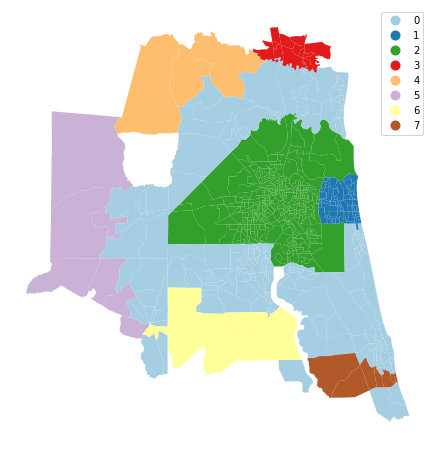

In [7]:
(zones_shp.merge(map_cbg_dir_zone)
 .query('aland > 0')
 .astype({'em_zone': 'category'})
 .plot(column='em_zone', figsize=(8, 8), cmap='Paired', legend=True)
)
plt.axis('off');

## Process demand file

In [8]:
def process_demand(fname, root='demand/Shen-scenarios',
                   zones=zones, shelts=shelts):
    """
    Read and process a demand CSV file.
    Convert the "long" demand format required by the simulator (where each
    pair of rows denotes one vehicle) to a wide format where each row denotes
    a vehicle and also includes whether the destination is a shelter.
    
    @param fname: <str> basename of the CSV file (without extension/directory)
    @param root: <str> folder containing the given file
    """
    # read the original demand file (should be CSV)
    raw = pd.read_csv(f'{root}/{fname}.csv')
    raw.columns = ['veh_id', 'GEOID', 'Departure']
    
    # get the set of 1st rows (contains info of origin) & map from TAZ to zone
    rows1 = (raw.iloc[::2]
             .merge(zones, on='GEOID')
             .rename(columns={'FID': 'orig', 'Departure': 'dep_time'})
             .drop(columns=['GEOID'])
            )
    # get the set of 2nd rows (contains info of destination & shelter)
    rows2 = raw.iloc[1::2].rename(columns={'Departure': 'is_shelter'})
    
    # separate the shelter and non-shelter vehicles & map from TAZ to zone
    shelt_rows = rows2.query('is_shelter == 1').merge(shelts, on='GEOID')
    zone_rows = rows2.query('is_shelter == 0').merge(zones, on='GEOID')
    
    # join them to get destination rows
    rows2 = (zone_rows.append(shelt_rows, ignore_index=True)
             .drop(columns=['GEOID'])
             .rename(columns={'FID': 'dest'})
            )
    # join them into 1 table
    demand = (pd.merge(rows1, rows2, on='veh_id')
              .sort_values('dep_time')
              .reset_index(drop=True)
             )
    # recreate vehicle IDs using the row numbers
    demand['veh_id'] = demand.index + 1
    
    return demand

In [9]:
base_dmd = process_demand('base')
peek(base_dmd)

Shape: (453750, 5)


,veh_id,dep_time,orig,is_shelter,dest
0,1,1,649,0,141
1,2,1,452,0,145
2,3,1,178,0,326


### Convert to format usable by simulator

In [10]:
def wide2long(demand, outfile=None):
    """
    Convert the prettified wide format of the demand to long format (as
    provided by Shen) where each pair of rows denotes a vehicle.
    Optionally, also export the table as CSV.
    
    @param demand: <pd.df> prettified form of the demand
    @param outfile: <str> path of the output file (CSV); if None, do not export
    """
    # get the origin rows
    rows1 = (demand[['veh_id', 'orig', 'dep_time']]
             .rename(columns={'veh_id': 'ID', 'orig': 'FID',
                              'dep_time': 'Departure'}))
    # get the destination rows
    rows2 = (demand[['veh_id', 'dest', 'is_shelter']]
             .rename(columns={'veh_id': 'ID', 'dest': 'FID',
                              'is_shelter': 'Departure'}))
    # append them
    result = (rows1.append(rows2, ignore_index=True)
              .sort_values(['ID', 'Departure'], ascending=[True, False])
              .reset_index(drop=True))
    
    # export to CSV
    if outfile is not None:
        result.to_csv(outfile, index=False)
    
    return result

In [11]:
peek(wide2long(base_dmd))

Shape: (907500, 3)


,ID,FID,Departure
0,1,649,1
1,1,141,0
2,2,452,1


### Plot the hourly demand profile

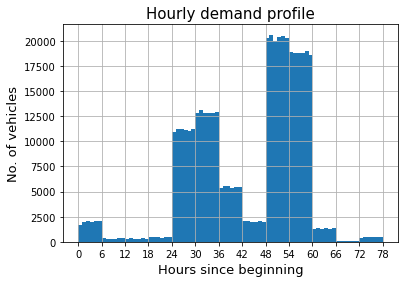

In [12]:
def plot_demand_profile(demand):
    (demand['dep_time']/60).hist(bins=78)
    plt.xticks(np.arange(0, 84, 6))
    plt.title('Hourly demand profile', fontsize=15)
    plt.xlabel('Hours since beginning', fontsize=13)
    plt.ylabel('No. of vehicles', fontsize=13)
    
plot_demand_profile(base_dmd)

### Process & export all demand scenarios

In [51]:
def process_scenarios(scenarios, out_dir='demand/Shen-scenarios', export=False):
    """
    Clean and prettify the demand of all of the given scenario names and store
    them in one table. Optionally also export these cleaned tables to their
    own files.
    @param scenarios: <[]> list of scenario names to be processed
    @param export: if true, export the cleaned table of each scenario with
    prefix 'clean'
    """
    # create combined demand table
    result = pd.DataFrame()
    
    # process all demand files and export their cleaned versions
    pbar = tqdm(scenarios)
    for scenario in pbar:
        pbar.set_description(f'Scenario: {scenario}')
        
        # read the demand in wide format
        dmd = process_demand(scenario)

        # add it to the overall demand table along with scenario name
        scenario = scenario.split('-')[0]
        sc_num = 0 if scenario == 'base' else int(scenario[1:])
        dmd.insert(0, 'scenario', sc_num)
        result = result.append(dmd, ignore_index=True)

        # convert to long format and export
        if export:
            wide2long(dmd, outfile=f'{out_dir}/{scenario}-clean.csv')
            
    # convert the data types to save space
    result = result.astype({'scenario': 'category', 'veh_id': np.int32,
                            'dep_time': np.int32, 'orig': np.int16,
                            'dest': np.int16, 'is_shelter': bool})
    return result

In [53]:
%%time
D = process_scenarios(['base-orig'] + [f'S{i+1}-orig' for i in range(12)], export=True)


CPU times: user 33.2 s, sys: 4.28 s, total: 37.5 s
Wall time: 38.3 s


### Get OD matrix

In [15]:
# unique IDs of the zones and shelters combined;
# used to construct the OD matrix
zone_ids = zones.append(shelts, ignore_index=True)['FID'].sort_values().values
print(zone_ids.size)

786


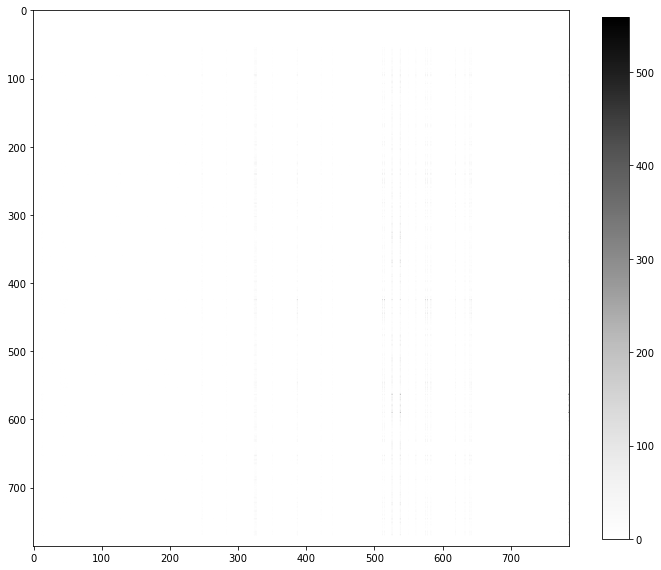

In [35]:
def create_od_mat(demand, zone_ids=zone_ids, plot=False):
    """
    Create an origin-destination (OD) demand matrix from a given demand table
    using a networkx graph.
    """
    # create the graph with all the nodes (zones+shelters)
    G = nx.DiGraph()
    G.add_nodes_from(zone_ids)
    
    # create the edge table
    edges = (demand.groupby(['orig', 'dest']).size()
             .rename('nVeh').reset_index().astype(np.int32).values)
    
    # add the edges to the graph
    for e in edges:
        G.add_edge(e[0], e[1], weight=e[2])
    
    # conver the sparse adjacency matrix to full NxN matrix (N = no. of nodes)
    A = nx.adjacency_matrix(G).A
    
    # plot the image
    if plot:
        fig, ax = plt.subplots(figsize=(12, 12))
        p = ax.imshow(A, cmap='Greys')
        fig.colorbar(p, ax=ax, shrink=0.8)
    
    return pd.DataFrame(A, columns=zone_ids, index=zone_ids)

_ = create_od_mat(base_dmd, plot=True)

### Get OD distribution
Plot the histogram of OD demand where x-axis is the OD ID and y-axis is the demand of that OD pair. Select only the top few most popular OD pairs across all the scenarios.

In [34]:
def compare_num_od(demand):
    """
    Compare the no. of OD pairs and total demand by scenario.
    """
    demand = demand.assign(sc_num = lambda x: x['scenario'].cat.codes)
    result = []
    for sc_num, df in demand.groupby('sc_num'):
        od_dmd = df.groupby(['orig', 'dest']).size().rename('nVeh')
        result.append({'scenario': sc_num, 'num_ods': od_dmd.size,
                       'total_demand': od_dmd.sum()})
    result = pd.DataFrame(result).set_index('scenario')
    return result

compare_num_od(D)

,num_ods,total_demand
scenario,,
0,81644,453750
1,85733,468704
2,89771,480609
3,80317,429783
4,79772,410794
5,82320,458024
6,83119,462466
7,83646,496146
8,83503,493950


CPU times: user 2.18 s, sys: 380 ms, total: 2.56 s
Wall time: 2.56 s


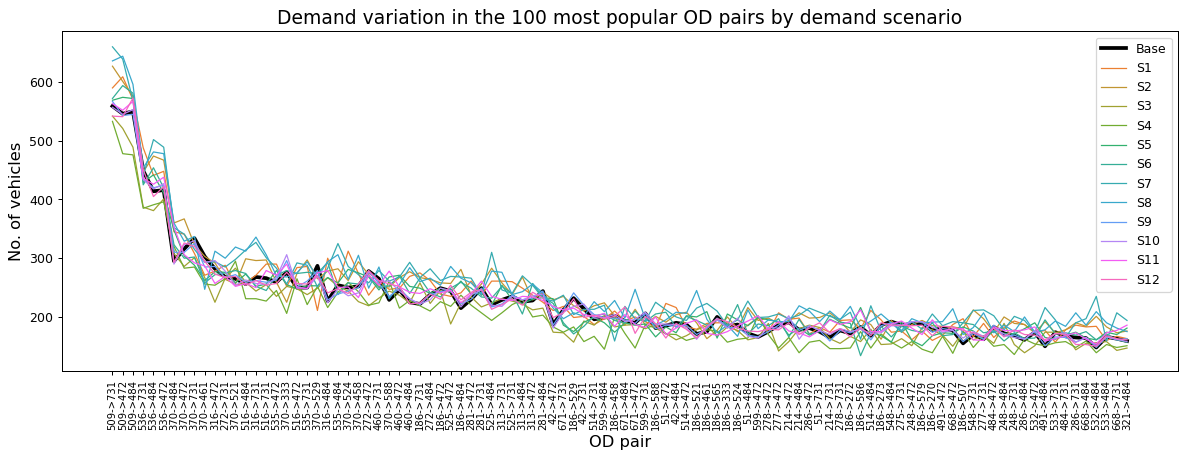

In [33]:
%%time
def plot_od_distr(D, top=100, figsize=(16, 5)):
    """
    Use the table containing the demand of all the scenarios and plot the
    histogram of the top few most popular OD pairs.
    """
    # get the list of all-scenario popular OD pairs
    pop_ods = (D.groupby(['orig', 'dest']).size().rename('nVeh')
               .sort_values(ascending=False).head(top).index)
    
    # now filter these ODPs in all of the scenarios
    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    
    colors = sns.color_palette('husl', len(D.groupby('scenario')))
    
    for (scenario, df), color in zip(D.groupby('scenario'), colors):
        # get the demand table for this scenario
        dmd = df.groupby(['orig', 'dest']).size().rename('nVeh')
        # filter only the popular ODPs
        dmd = dmd.loc[pop_ods].reset_index()
        # format the OD pair labels
        dmd['od_id'] = dmd['orig'].astype(str) + '->' + dmd['dest'].astype(str)
        
        # plot the demand by ODP
        if scenario == 0: # special formatting for base scenario
            color, linewidth, sc_name = 'black', 3, 'Base'
        else:
            linewidth, sc_name = 1, f'S{scenario}'
        # calculate the total demand & no. of ODs in this scenario to be added to label
        od_dmd = D[D['scenario'] == scenario].groupby(['orig', 'dest']).size()
        label = sc_name
                    
        ax.plot(dmd['od_id'], dmd['nVeh'], color=color, lw=linewidth, label=label)
        
        # format the xticks
        ticks_loc = ax.get_xticks()
        ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
        ax.set_xticklabels(dmd['od_id'], rotation=90, fontsize=8)
    ax.legend()
    plt.title(f'Demand variation in the {top} most popular OD pairs by demand scenario',
              fontsize=15)
    plt.xlabel('OD pair', fontsize=13)
    plt.ylabel('No. of vehicles', fontsize=13)
    
plot_od_distr(D)

### Get OD distribution (big zones)

CPU times: user 3.2 s, sys: 694 ms, total: 3.89 s
Wall time: 3.9 s


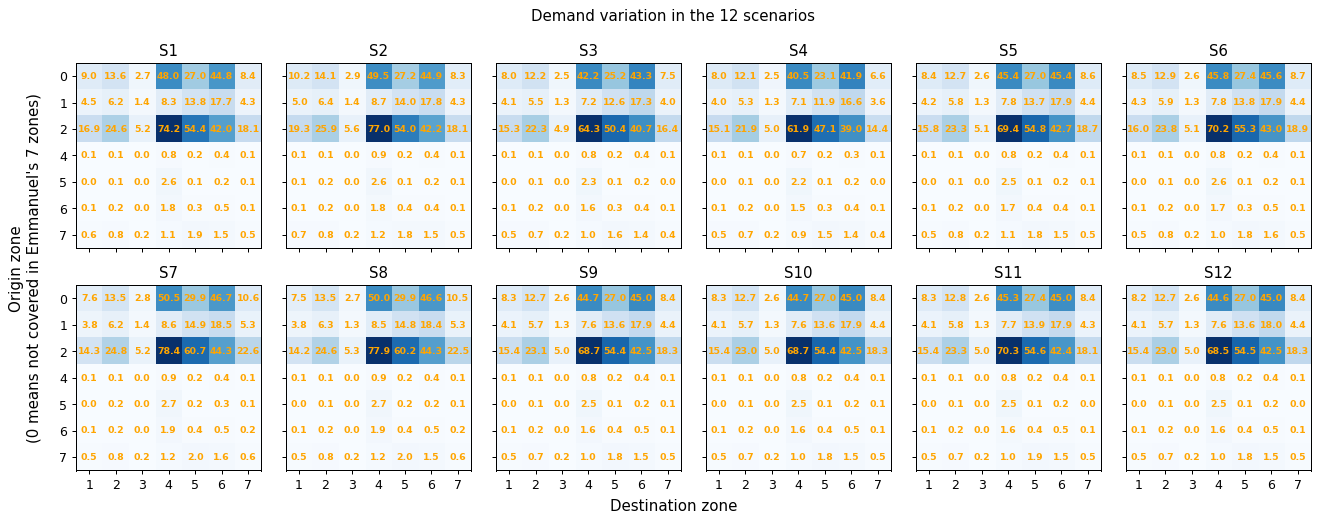

In [32]:
%%time
def plot_od_distr_big(D, zones=zones, map_cbg_dir_zone=map_cbg_dir_zone, plot_base=False):
    """
    Use the table containing the demand of all the scenarios and plot the
    histogram of the top few most popular OD pairs.
    """
    # get the mapping between destination zone IDs (FID) & directional zones
    dest_zone_to_em_zone = (map_cbg_dir_zone
                            .merge(zones.rename(columns={'GEOID': 'cbg'}), on='cbg')
                            .drop(columns=['cbg'])
                            .set_index('FID'))
    
    # convert the destination zones to directional zones
    res = (
        D.merge(dest_zone_to_em_zone, left_on='orig', right_index=True)
        .rename(columns={'em_zone': 'orig_zone'})
        .merge(dest_zone_to_em_zone, left_on='dest', right_index=True)
        .rename(columns={'em_zone': 'dest_zone'})
        .reset_index(drop=True)
        .astype({'scenario': int})
        [['scenario', 'veh_id', 'orig_zone', 'dest_zone', 'dep_time']]
    )
    
    # plot
    if plot_base:
        pass
    else:
        fig, axs = plt.subplots(2, 6, figsize=(18, 6), sharex=True, sharey=True, dpi=90)
        axs = axs.flatten()
        # skip the base scenario
        res = res.query('scenario != 0')
        for k, (scenario, df) in enumerate(res.groupby('scenario')):
            ax = axs[k]
            # get the demand table for this scenario
            dmd = (df.groupby(['orig_zone', 'dest_zone']).size()
                   .rename('nVeh').reset_index()
                   .pivot(index='orig_zone', columns='dest_zone', values='nVeh'))
            X = dmd.columns.astype(str)
            Y = dmd.index.astype(str)
            
            # plot the image
            ax.imshow(dmd.values, cmap='Blues')
            
            # plot the cell labels
            for i in range(len(X)):
                for j in range(len(Y)):
                    txt = ax.text(j, i, f'{dmd.iloc[i, j]/1e3:.1f}', color='orange',
                                  ha='center', va='center', fontsize=7.5, fontweight='bold')
                    # txt.set_path_effects(
                    #     [effects.withStroke(linewidth=2, foreground='w')])
            
            # format the labels & title
            ax.set_title(f'S{scenario}')
            ax.set_xticks(np.arange(0, len(X), 1))
            ax.set_yticks(np.arange(0, len(Y), 1))
            ax.set_xticklabels(X)
            ax.set_yticklabels(Y)
        fig.suptitle('Demand variation in the {} scenarios'
                  .format(len(res.groupby('scenario')), fontsize=15))
        fig.text(0.1, 0.5, "Origin zone\n(0 means not covered in Emmanuel's 7 zones)",
                 rotation=90, ha='center', va='center', fontsize=12)
        fig.text(0.5, 0.05, 'Destination zone', ha='center', fontsize=12)
        plt.subplots_adjust(wspace=0.02)

plot_od_distr_big(D)